In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import glob
import sys
import urllib.request
import os
import pandas as pd
import imageio
import string
import cv2
from PIL import Image
import keras
import skimage.transform
from random import randint
from sklearn.model_selection import train_test_split
import operator
import seaborn as sns





In [0]:
zip_file_url = "https://github.com/yoavram/Sign-Language/raw/master/Dataset.zip"
filename = '../data/sign-lang/.zip'
if not os.path.exists('../data'):
    os.mkdir('../data')
if not os.path.exists('../data/sign-lang'):
    os.mkdir('../data/sign-lang')
if not os.path.exists(filename):
    urllib.request.urlretrieve(zip_file_url, filename)


zipf = zipfile.ZipFile(filename)
zipf.extractall("../data/sign-lang/Dataset")

In [0]:
def array_init():
    user_numbers = ['user_3', 'user_4', 'user_5', 'user_6', 'user_7', 'user_9', 'user_10']
    return user_numbers

def imgs_to_array(users_numbers):
  imgs = [] 
  for user_number in users_numbers:
    imgs.append([imageio.imread(f) for f in sorted(glob.glob('../data/sign-lang/Dataset/Dataset/%s/*.jpg'%(user_number)))])
  return np.array(imgs)
users_numbers = array_init()

In [0]:
def preprocess(img,size):
    #reducing the whole image into a hand image
    hand_img = img[size[1]:size[3],size[0]:size[2]]

    #cropping the image to the wanted fixed size
    hand_img_cropped_size = cv2.resize(hand_img,((90,90)))

    return hand_img_cropped_size

In [0]:
def imgs_crop():
    usrs= array_init()
    uncropped_imgs_arr = imgs_to_array(users_numbers)
    cropped_imgs_arr = []
    labels_arr = []
    cur_label = 65
    
    #Extracting CSV information
    df = pd.DataFrame()
    sizes_of_imgs = []
    CSV_file_end = '_loc.csv'
    for usr in usrs:
      info = np.genfromtxt(('../data/sign-lang/Dataset/Dataset/%s/%s%s'%(usr,usr,CSV_file_end)), delimiter=',')
      #extracting only the relevant size information
      sizes_of_imgs.append(info[1:,1:5])
    sizes_of_imgs = np.array(sizes_of_imgs).astype(int)
    label_counter = 1
    
    #cropping imgs
    for usr, usr_i in zip(users_numbers,range(len(users_numbers))):
        cur_label = 65
        label_counter = 1
        for img, img_i in zip(uncropped_imgs_arr[usr_i],range(len(uncropped_imgs_arr[usr_i]))):
                cur_img_size = sizes_of_imgs[usr_i][img_i]
                cropped_imgs_arr.append(preprocess(uncropped_imgs_arr[usr_i][img_i],cur_img_size))
                labels_arr.append(chr(cur_label))
                if(label_counter % 10 == 0):
                    cur_label+=1
                if(chr(cur_label) == 'J'):
                    cur_label+=1
                label_counter+=1
    return np.array(cropped_imgs_arr), np.array(labels_arr)

In [0]:
def one_hot_encoding(labels_arr):
  num_of_unique_labels = (len(np.unique(labels_arr))) 
  number_of_imgs = len(labels_arr)
  encoded_arrays = np.zeros((number_of_imgs, num_of_unique_labels))
  correct_label_index = 0
  for cur_label, cur_label_i in zip(labels_arr, range(len(labels_arr))):
    #putting the right index because 'J' is missing
    if(ord(cur_label) < ord('J')):
      correct_label_index = ord(cur_label) - 65
    else:
      correct_label_index = ord(cur_label) - 66
    encoded_arrays[cur_label_i][correct_label_index] = 1
  return encoded_arrays  
imgs_arr , labels = imgs_crop()

In [0]:
#splitting the data to training/test sets. images and labels accordingly.
cropped_imgs_arr, labels_arr = imgs_crop()
labels_arr = one_hot_encoding(labels_arr)
train_imgs, test_imgs, train_labels, test_labels = train_test_split(cropped_imgs_arr, labels_arr)
#normalizing
train_imgs = train_imgs / 255

In [45]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), input_shape=(90, 90, 3)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(16, (3, 3)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))
num_classes = 24
model.add(keras.layers.Dense(num_classes))
model.add(keras.layers.Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

history = model.fit(
    train_imgs, train_labels,
    batch_size=50,
    epochs=200,
    validation_data=(test_imgs, test_labels)
).history

Train on 1260 samples, validate on 420 samples
Epoch 1/200
1260/1260 [==============================] - 17s 13ms/step - loss: 3.1995 - acc: 0.0444 - val_loss: 15.1106 - val_acc: 0.0500
Epoch 2/200
1260/1260 [==============================] - 16s 13ms/step - loss: 3.1250 - acc: 0.0786 - val_loss: 13.3367 - val_acc: 0.1357
Epoch 3/200
1260/1260 [==============================] - 16s 13ms/step - loss: 3.0401 - acc: 0.1302 - val_loss: 14.6248 - val_acc: 0.0643
Epoch 4/200
1260/1260 [==============================] - 16s 13ms/step - loss: 2.9156 - acc: 0.2016 - val_loss: 12.3656 - val_acc: 0.2048
Epoch 5/200
1260/1260 [==============================] - 16s 13ms/step - loss: 2.7353 - acc: 0.2754 - val_loss: 9.7378 - val_acc: 0.3786
Epoch 6/200
1260/1260 [==============================] - 16s 13ms/step - loss: 2.5297 - acc: 0.3492 - val_loss: 10.1045 - val_acc: 0.3429
Epoch 7/200
1260/1260 [==============================] - 16s 13ms/step - loss: 2.3253 - acc: 0.3905 - val_loss: 11.0391 - val_

In [46]:
# Score trained model.
loss, acc = model.evaluate(test_imgs, test_labels, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', acc)

420/420 [==============================] - 2s 4ms/step
Test loss: 2.3409620194208056
Test accuracy: 0.8547619047619047


In [0]:
def finding_the_label_from_arr(bool_arr):
  index, _ = max(enumerate(bool_arr), key=operator.itemgetter(1))
  if(index < ord("J") - 65):
    index = index + 65
  else:
    index = index + 66
  return chr(index)

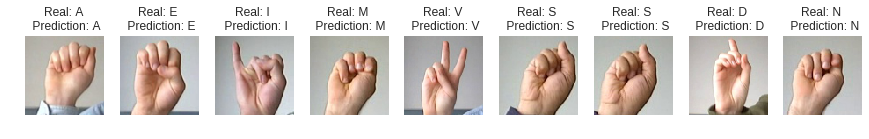

In [48]:
def visual(imgs_arr,labels_arr):
  #choosing 9 random images
  rand_num_arr = np.zeros(9)
  rand_num_arr = [randint(0, len(imgs_arr)) for x in range(0, 9)]
  random_9_imgs_arr = imgs_arr[rand_num_arr]
  random_9_labels_arr = labels_arr[rand_num_arr]
  
  #getting their prediction
  label_of_img_prediction = model.predict(random_9_imgs_arr)
  
  #plotting and showing the real value of the image compared to the prediction of the model
  plt.figure(figsize=[15,15])
  for i in range(len(random_9_labels_arr)):
    plt.subplot(1,9,i+1)
    plt.axis('off')
    plt.imshow(random_9_imgs_arr[i])
    plt.title("Real: %s \n Prediction: %s"%( finding_the_label_from_arr(random_9_labels_arr[i]),finding_the_label_from_arr(label_of_img_prediction[i])))
    
visual(train_imgs, train_labels)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


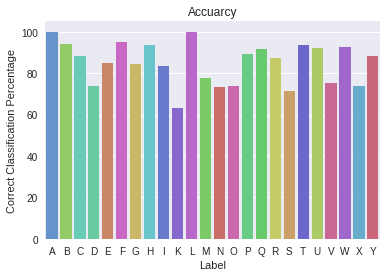

In [51]:
def accuarcy_of_classes():
  #getting both labels of the real and of the prediction
  predictions = [finding_the_label_from_arr(x) for x in model.predict(test_imgs)]
  test_labels_letters = [finding_the_label_from_arr(x) for x in test_labels]
  
  #comparing between the two results
  isEqual = [predictions[i] == test_labels_letters[i] for i in range(len(predictions))]
  
  #counting the number of misclassified data points
  counting_array_of_true = np.zeros(24)
  counting_array_of_labels = np.zeros(24)
  for i in range(len(test_labels_letters)):
      cur_label = ord(test_labels_letters[i])-65 if ord(test_labels_letters[i]) < ord("J") else ord(test_labels_letters[i])-66
      if(isEqual[i]==True):
        counting_array_of_true[cur_label]+=1
      counting_array_of_labels[cur_label]+=1
  
  #converting it to precentage of misclassification
  probability_of_classified_arr = (counting_array_of_true/counting_array_of_labels)*100
  
  #plotting the misclassifiction stats
  pal = sns.color_palette("hls", len(probability_of_classified_arr))
  sorted_array_of_prob = probability_of_classified_arr.argsort()
  g = sns.barplot(x=np.unique(test_labels_letters), palette=np.array(pal[::-1])[sorted_array_of_prob],  y=probability_of_classified_arr)
  plt.title("Accuarcy")
  plt.ylabel('Correct Classification Percentage')
  plt.xlabel('Label')

  
accuarcy_of_classes()
